In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import math
import pickle

In [36]:
data_dir = './data/'
X = pd.read_csv(data_dir+'features.csv')
X.set_index('Unnamed: 0', inplace=True)
display(X.shape)


geneset_dict = pickle.load(open(data_dir + 'hallmarks_of_cancer_geneset_dictionary.pkl','rb'))
all_hallmark_genes = np.unique(np.concatenate([v for k,v in geneset_dict.items()]))
len(all_hallmark_genes)

X_sub = X.loc[:,np.intersect1d(X.columns.values,all_hallmark_genes)]
display(X_sub.shape)
X_sub.head()

(139, 20501)

(139, 4223)

,A2M,AAAS,AADAT,AARS,ABAT,ABCA1,ABCA2,ABCA3,ABCA4,ABCA5,...,ZNF365,ZNF639,ZNF707,ZNFX1,ZNRD1,ZNRF4,ZPBP,ZW10,ZWINT,ZYX
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
tcga-2y-a9gt-2,19515,773,479,3542,12577,3133,2186,70,25,2316,...,1,412,141,1564,260,0,0,399,287,3220
tcga-2y-a9gv-4,8756,828,616,6088,23069,2885,1129,110,39,2132,...,2,347,124,1320,339,0,0,642,100,2903
tcga-2y-a9gw-5,43813,622,49,4758,7663,1649,2252,96,58,1284,...,6,431,646,935,361,0,0,351,221,8467
tcga-2y-a9gy-7,11699,1179,81,2991,966,1559,935,22,28,641,...,2,371,264,709,584,0,0,318,735,3825
tcga-2y-a9gz-8,264407,919,1435,3304,21557,1762,2134,107,42,2779,...,2,514,156,874,285,0,0,648,259,1394


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 255))
X_scaled = scaler.fit_transform(X_sub)
X_scaled

array([[  7.14597741,  53.53433836,  49.21052632, ..., 143.00675676,
         26.37931034,  48.65076772],
       [  2.82400479,  61.36515913,  63.46389229, ..., 247.67736486,
          7.90391321,  43.36916041],
       [ 16.90666992,  32.03517588,   4.47368421, ..., 122.33108108,
         19.85858194, 136.07219863],
       ...,
       [  0.63309126, 107.4958124 ,  45.77723378, ..., 143.4375    ,
         19.06819062,  10.74648808],
       [ 29.64682808,  59.08710218,  11.96450428, ..., 133.09966216,
         56.61177838, 176.79222476],
       [ 28.37341483,  26.90954774,   6.34638923, ...,  97.77871622,
          7.90391321,  62.12969618]])

In [42]:
# transform each row in the dataset into an image

# create a 2d array of 0s that has the dimensions (sqrt(data.shape[1]), sqrt(data.shape(1)))
def reshape_df(data):
    if (math.sqrt(data.shape[1])).is_integer() == False:
        dim = round(math.sqrt(data.shape[1]))
    else: 
        dim = math.sqrt(data.shape[1])

    imgs = []
    zeros = [0] * (dim ** 2 - data.shape[1])

    for row in range(len(data)):
        # reshapes sample to image
        sample = data.iloc[row,:].values.tolist()
        sample += zeros 
        sample = np.reshape(a=sample, newshape=(dim, dim))
        sample = scale_to_rgb(sample)
        imgs.append(sample)
        
    return imgs


In [43]:
def scale_to_rgb(float_array):
    scaled = float_array/255
    rounded_up = (np.ceil(scaled)).astype(int)
    # print(rounded_up.dtype)
    return rounded_up

In [59]:
imgs = reshape_df(X_sub)
display(len(imgs))

139

In [60]:
X = np.array(imgs)
y = pd.read_csv(data_dir + 'labels.csv', index_col=0)
y = y.to_numpy().ravel()

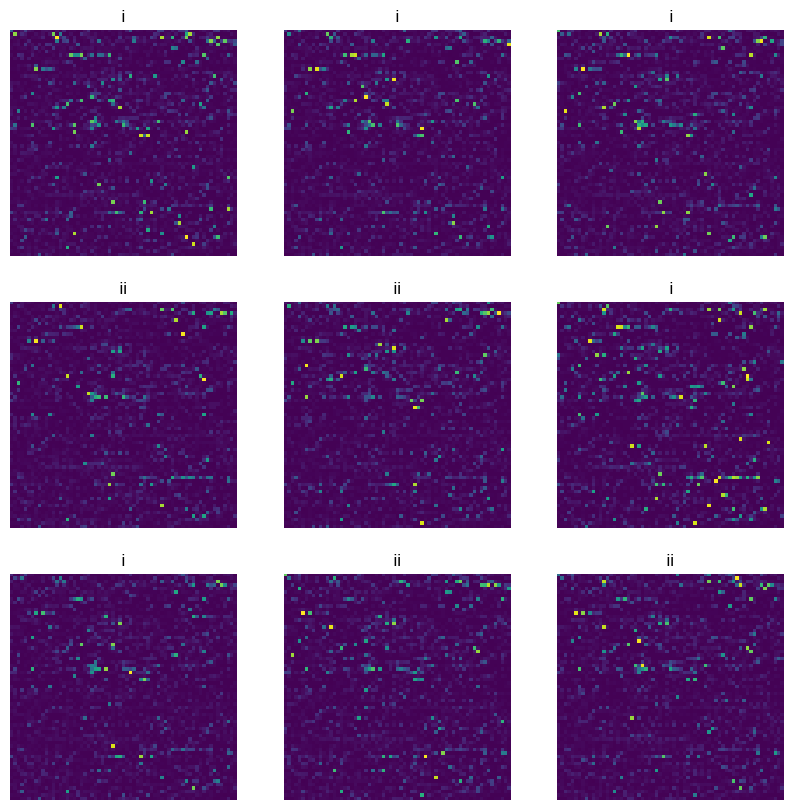

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs[i].astype("uint8"))
    plt.title(y[i])
    plt.axis("off")

In [62]:
# train test split 
import tensorflow as tf
le = LabelEncoder()

y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

trainY = tf.keras.utils.to_categorical(y_train, num_classes=3)
testY = tf.keras.utils.to_categorical(y_test, num_classes=3)

display(X_train.shape)
display(X_test.shape)

(111, 65, 65)

(28, 65, 65)

In [63]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

model = tf.keras.models.Sequential()

model.add(layers.Conv2D(64, kernel_size=(4, 4), strides=(1,1), padding='same', activation='relu', input_shape=(65, 65,1)))
model.add(layers.Conv2D(128, kernel_size=(2, 2), strides=(1, 1), padding="same", activation='relu'))
model.add(layers.Conv2D(256, kernel_size=(1, 1), strides=(1, 1), padding="same", activation='relu'))

model.add(layers.MaxPooling2D((2, 2), strides=2))
model.add(layers.BatchNormalization(epsilon=1e-05, momentum=0.1))
model.add(layers.Dropout(rate=0.25))
model.add(layers.Flatten())

 
model.add(layers.Dense(512, use_bias=True, activation='relu'))
# model.add(tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), input_shape=(65, 65,1), padding='same'))
# model.add(tf.keras.layers.Conv2D(32, (3, 3), padding = 'same', activation='relu'))
# model.add(tf.keras.layers.MaxPooling2D(pool_size=(2,2)))
# model.add(tf.keras.layers.Dropout(0.2))

# model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding='same', activation = "relu")) 
# model.add(tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), padding = 'same', activation = "relu")) 
# model.add(tf.keras.layers.MaxPooling2D(pool_size = (2,2)))
# model.add(tf.keras.layers.Dropout(rate=0.3))


# model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation = "relu"))
# model.add(tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), padding = 'same', activation = "relu"))
# model.add(tf.keras.layers.MaxPooling2D(pool_size =(2,2)))
# model.add(tf.keras.layers.Dropout(rate=0.4))

model.add(layers.Dense(128, activation='relu'))
# model.add(layers.Dense(32,activation='relu'))
model.add(layers.Dense(3,activation='sigmoid'))

optimizer = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 65, 65, 64)        1088      
                                                                 
 conv2d_7 (Conv2D)           (None, 65, 65, 128)       32896     
                                                                 
 conv2d_8 (Conv2D)           (None, 65, 65, 256)       33024     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 256)      1024      
 hNormalization)                                                 
                                                                 
 dropout_2 (Dropout)         (None, 32, 32, 256)      

In [64]:
history = model.fit(
        X_train,
        trainY,
        epochs=100,
        validation_data=(X_test, testY)
    )

Epoch 1/100
4/4 [==============================] - 8s 2s/step - loss: 8.5783 - accuracy: 0.4054 - val_loss: 9.7438 - val_accuracy: 0.3929
Epoch 2/100
4/4 [==============================] - 9s 2s/step - loss: 4.6855 - accuracy: 0.4685 - val_loss: 8.5417 - val_accuracy: 0.2500
Epoch 3/100
4/4 [==============================] - 7s 2s/step - loss: 2.8886 - accuracy: 0.3964 - val_loss: 1.3912 - val_accuracy: 0.4286
Epoch 4/100
4/4 [==============================] - 9s 2s/step - loss: 1.1502 - accuracy: 0.4955 - val_loss: 2.9066 - val_accuracy: 0.2857
Epoch 5/100
4/4 [==============================] - 8s 2s/step - loss: 1.0824 - accuracy: 0.6486 - val_loss: 1.6818 - val_accuracy: 0.3214
Epoch 6/100
4/4 [==============================] - 7s 2s/step - loss: 0.7996 - accuracy: 0.6577 - val_loss: 1.6643 - val_accuracy: 0.3571
Epoch 7/100
4/4 [==============================] - 5s 1s/step - loss: 1.0893 - accuracy: 0.5405 - val_loss: 2.3872 - val_accuracy: 0.3214
Epoch 8/100
4/4 [=================

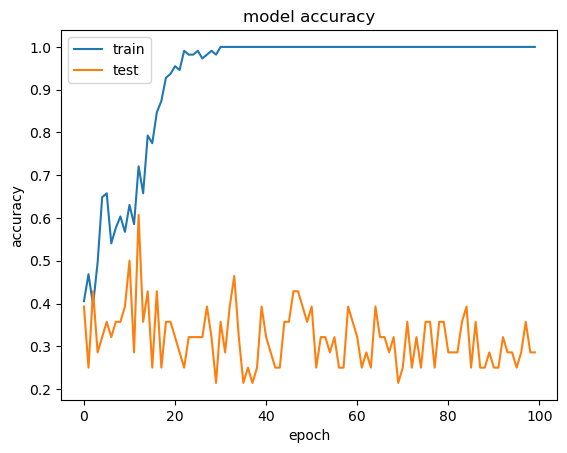

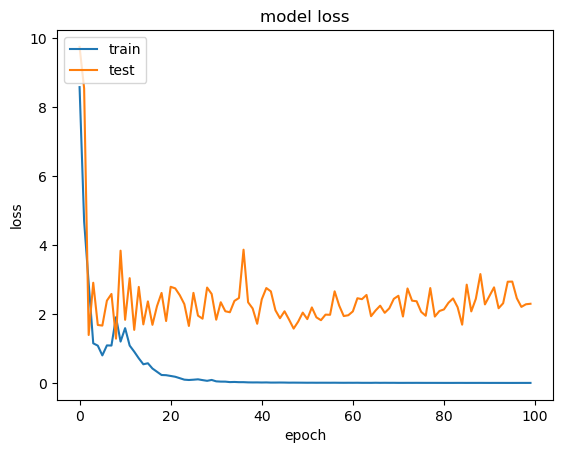

In [65]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

1/1 [==============================] - 1s 894ms/step


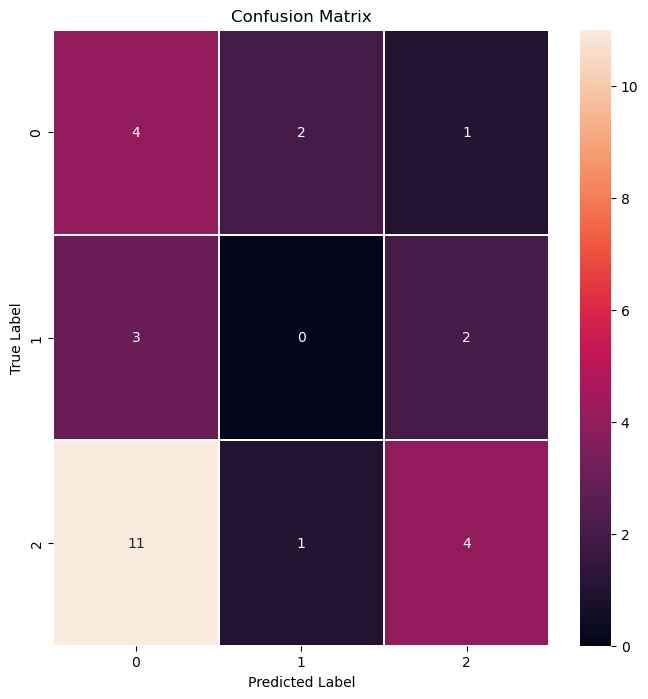

In [71]:
# confusion matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
# Predict the values from the validation dataset
y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred,axis = 1) 

# compute the confusion matrix
confusion_mtx = confusion_matrix(y_test, y_pred_classes) 
# # plot the confusion matrix
f,ax = plt.subplots(figsize=(8, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

### To Do:
1. Address overfitting - Data augmentation
2. K-fold CV
3. Try filtering out genes with little change in expression

In [ ]:
def filter_genes(df, threshold):
    df = df.loc[:, df.var(axis=0) < threshold]
    return df